### **1. Transformers DistilBert + Plain Teks**

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.1 MB/s eta 0:00:00
Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/7425 [00:00<?, ? examples/s]

Map:   0%|          | 0/2475 [00:00<?, ? examples/s]

Map:   0%|          | 0/2475 [00:00<?, ? examples/s]

Model telah ada? (y=latih ulang / n=gunakan saja): y


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

<ipython-input-1-3fe66a6189c6>:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.006900,0.006403,0.970101,0.969320
2,0.006900,0.005424,0.974141,0.973878
3,0.002400,0.005244,0.976566,0.976210
4,0.004100,0.004977,0.976566,0.976230


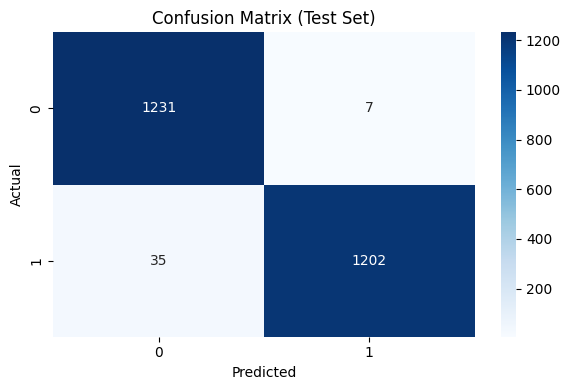

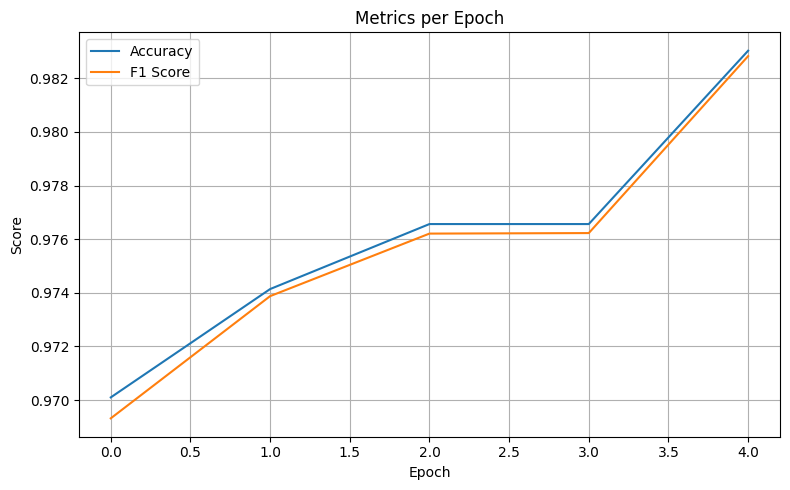

{'Model': 'DistilBERT',
 'Training Time (s)': 476.87,
 'Inference Time (s)': 9.28,
 'CPU Usage (%)': 59.2,
 'RAM Usage (MB)': 704.0,
 'Model Size (MB)': 253.95,
 'Final Test Acc': 0.983,
 'Final Test F1': 0.9828,
 'Final Test Precision': 0.9942,
 'Final Test Recall': 0.9717}

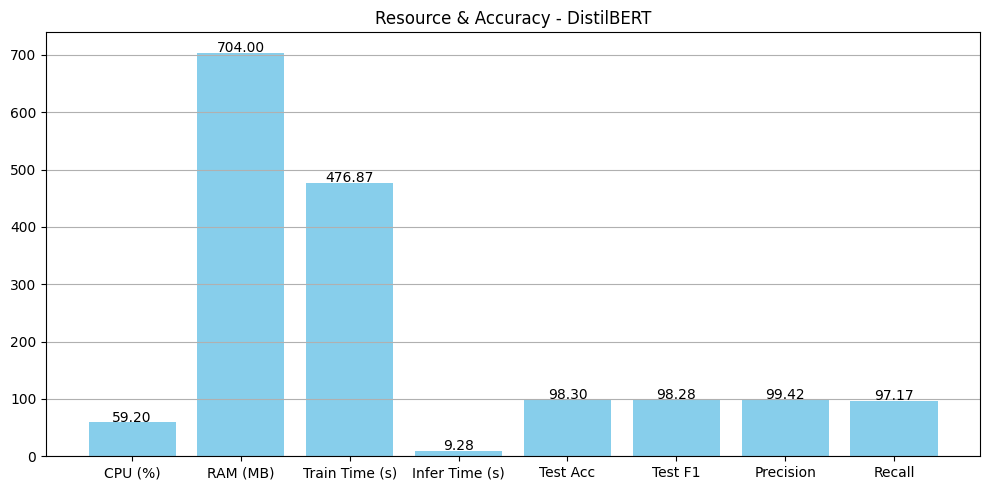

✅ Training & Evaluasi Selesai. Semua file disimpan di:
/content/drive/My Drive/Colab Notebooks/5. Output/3. Transformers/Text Only


In [ ]:
# 128 Token
# ========================== [1] Install & Import ==========================
!pip install transformers datasets evaluate --quiet

import os, time, random, psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, DistilBertModel, PreTrainedModel, DistilBertConfig, DataCollatorWithPadding
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import Dataset
from google.colab import drive

# ========================== [2] Seed & Mount Drive ==========================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
drive.mount('/content/drive')

#==================== Check Model Size =================================
def get_model_size_mb(path):
    full_path = os.path.join(path, "pytorch_model.bin")
    size_bytes = os.path.getsize(full_path)
    return round(size_bytes / (1024 * 1024), 2)

# ========================== [3] Load Dataset ==========================
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Dataset After Preprocessing/5. Plain Text Only + Fitur PFA, Ablation dan PFI.csv")
df.dropna(subset=["filename", "label", "plain_text_only"], inplace=True)
df["text"] = df["plain_text_only"].astype(str)
df["label"] = df["label"].astype(int)

# ========================== [4] Train-Val-Test Split (60/20/20) ==========================
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df["label"], random_state=seed)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=seed)

# ========================== [5] Tokenizer & Dataset ==========================
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize_function(example):
    encoding = tokenizer(
        example["text"],
        truncation=True,
        padding=False,  # atau True jika ingin padding langsung
        max_length=128  # ⬅️ Batasi ke 128 token
    )
    return encoding

train_dataset = Dataset.from_pandas(train_df[["text", "label"]].reset_index(drop=True)).map(tokenize_function, batched=True)
val_dataset   = Dataset.from_pandas(val_df[["text", "label"]].reset_index(drop=True)).map(tokenize_function, batched=True)
test_dataset  = Dataset.from_pandas(test_df[["text", "label"]].reset_index(drop=True)).map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#========================OPTIMIZER======================================
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(logits, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class CustomDistilBERT(PreTrainedModel):
    config_class = DistilBertConfig

    def __init__(self, config):
        super().__init__(config)
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.hidden = nn.Sequential(
            nn.Linear(config.dim, 256),     # 768 → 256
            #nn.BatchNorm1d(256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, config.num_labels)
        )
        self.focal_loss = FocalLoss(alpha=0.25, gamma=2.0)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]  # Ambil token [CLS]
        logits = self.hidden(cls_output)

        loss = None
        if labels is not None:
            loss = self.focal_loss(logits, labels)

        return SequenceClassifierOutput(loss=loss, logits=logits)

# ========================== [6] Model Path Check ==========================
model_dir = "/content/drive/My Drive/Colab Notebooks/5. Output/3. Transformers/Text Only"
os.makedirs(model_dir, exist_ok=True)

model_path = model_dir
retrain = input(f"Model telah ada? (y=latih ulang / n=gunakan saja): ").strip().lower() == 'y'

if os.path.exists(model_path) and not retrain:
  config = DistilBertConfig.from_pretrained(model_path)
  model = CustomDistilBERT(config)
  model.load_state_dict(torch.load(os.path.join(model_path, "pytorch_model.bin")))
else:
  config = DistilBertConfig.from_pretrained("distilbert-base-uncased", num_labels=2)
  model = CustomDistilBERT(config)

# ========================== [7] Training Arguments ==========================
output_dir = "/content/drive/My Drive/Colab Notebooks/5. Output/3. Transformers/Text Only"
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir=os.path.join(output_dir, "logs"),
    num_train_epochs=4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=10,
    save_total_limit=2,
    report_to="none",
    logging_first_step=True,

    # 🔽 Tambahkan ini di bagian bawah
    lr_scheduler_type="linear",
    warmup_steps=200
)

# ========================== [8] Metrics ==========================
history = {"eval_accuracy": [], "eval_f1": [], "eval_loss": []}
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    history["eval_accuracy"].append(acc)
    history["eval_f1"].append(f1)
    return {"accuracy": acc, "f1": f1}

# ========================== [9] Resource Tracking & Training ==========================
if retrain or not os.path.exists(model_path):
    start_time = time.time()
    cpu_before = psutil.cpu_percent(interval=None)
    ram_before = psutil.Process().memory_info().rss / (1024 * 1024)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    torch.save(model.state_dict(), os.path.join(model_path, "pytorch_model.bin"))
    tokenizer.save_pretrained(model_path)

# ========================== [10] Final Evaluation & Save Results ==========================
trainer.model.eval()
start_infer = time.time()
preds = trainer.predict(test_dataset)
end_infer = time.time()
infer_time = round(end_infer - start_infer, 2)

#End Training
cpu_after = psutil.cpu_percent(interval=None)
ram_after = psutil.Process().memory_info().rss / (1024 * 1024)
end_time = time.time()

y_true = np.array(preds.label_ids)
y_pred = np.argmax(preds.predictions, axis=1)

# Calculate final precision and recall here
final_precision = precision_score(y_true, y_pred)
final_recall = recall_score(y_true, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.show()

# False Predictions
test_df = test_df.reset_index(drop=True)
false_preds = test_df.copy()
false_preds["True Label"] = y_true
false_preds["Predicted Label"] = y_pred
false_preds = false_preds[false_preds["True Label"] != false_preds["Predicted Label"]]
false_preds.to_csv(f"{output_dir}/false_predictions.csv", index=False)

# Plot Accuracy & F1 over Epochs
if len(history["eval_accuracy"]) > 0:
    plt.figure(figsize=(8, 5))
    plt.plot(history["eval_accuracy"], label='Accuracy')
    plt.plot(history["eval_f1"], label='F1 Score')
    plt.title("Metrics per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/training_metrics_curve.png")
    plt.show()

# Resource Log
log = {
    "Model": "DistilBERT",
    "Training Time (s)": round(end_time - start_time, 2) if retrain else "Loaded",
    "Inference Time (s)": infer_time,
    "CPU Usage (%)": cpu_after if retrain else "N/A",
    "RAM Usage (MB)": round(ram_after - ram_before, 2) if retrain else "N/A",
    "Model Size (MB)": get_model_size_mb(model_path),
    "Final Test Acc": round(accuracy_score(y_true, y_pred), 4),
    "Final Test F1": round(f1_score(y_true, y_pred), 4),
    "Final Test Precision": round(final_precision, 4),
    "Final Test Recall": round(final_recall, 4)
}

def plot_resource_and_accuracy(log):
    plt.figure(figsize=(10, 5))
    labels = ["CPU (%)", "RAM (MB)", "Train Time (s)", "Infer Time (s)", "Test Acc", "Test F1", "Precision", "Recall"]
    values = [
        log["CPU Usage (%)"] if isinstance(log["CPU Usage (%)"], (int, float)) else 0,
        log["RAM Usage (MB)"] if isinstance(log["RAM Usage (MB)"], (int, float)) else 0,
        log["Training Time (s)"] if isinstance(log["Training Time (s)"], (int, float)) else 0,
        log["Inference Time (s)"],
        log["Final Test Acc"] * 100,
        log["Final Test F1"] * 100,
        log["Final Test Precision"] * 100,
        log["Final Test Recall"] * 100
    ]
    bars = plt.bar(labels, values, color='skyblue')
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{value:.2f}", ha='center')
    plt.title(f"Resource & Accuracy - {log['Model']}")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/resource_accuracy_plot.png")
    plt.show()

display (log)
plot_resource_and_accuracy(log)
print("✅ Training & Evaluasi Selesai. Semua file disimpan di:")
print(output_dir)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00
Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/7425 [00:00<?, ? examples/s]

Map:   0%|          | 0/2475 [00:00<?, ? examples/s]

Map:   0%|          | 0/2475 [00:00<?, ? examples/s]

Model telah ada? (y=latih ulang / n=gunakan saja): y


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

<ipython-input-1-84eb6d68860e>:158: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.004100,0.006081,0.973737,0.973129
2,0.003800,0.004696,0.978182,0.977778
3,0.002700,0.004479,0.978990,0.978706
4,0.001800,0.004300,0.979798,0.979558


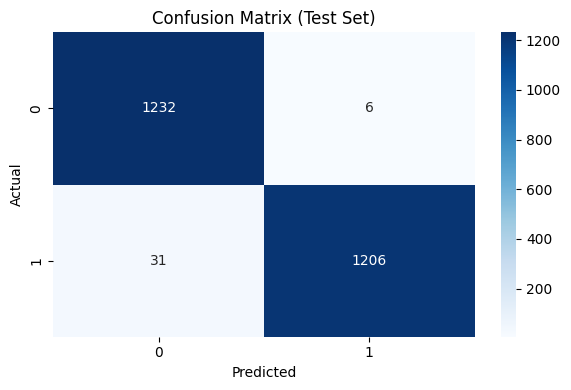

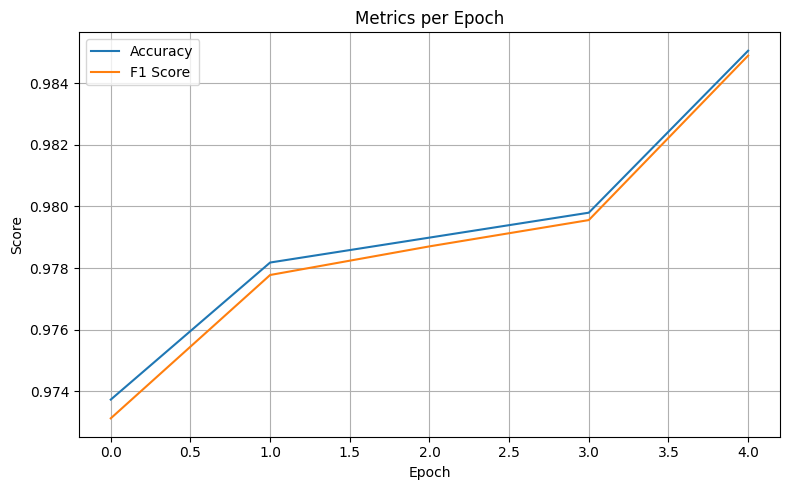

{'Model': 'DistilBERT',
 'Training Time (s)': 785.15,
 'CPU Usage (%)': 64.2,
 'RAM Usage (MB)': 700.13,
 'Final Test Acc': 0.9851,
 'Final Test F1': 0.9849}

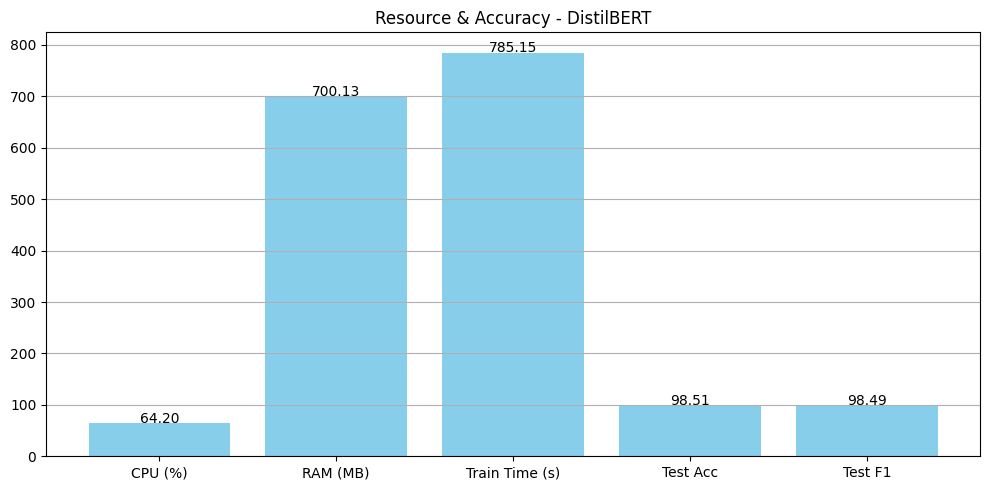

✅ Training & Evaluasi Selesai. Semua file disimpan di:
/content/drive/My Drive/Colab Notebooks/5. Output/3. Transformers/Text Only


In [ ]:
# 256 Token
# ========================== [1] Install & Import ==========================
!pip install transformers datasets evaluate --quiet

import os, time, random, psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, DistilBertModel, PreTrainedModel, DistilBertConfig, DataCollatorWithPadding
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import Dataset
from google.colab import drive

# ========================== [2] Seed & Mount Drive ==========================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
drive.mount('/content/drive')

# ========================== [3] Load Dataset ==========================
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Dataset After Preprocessing/5. Plain Text Only + Fitur PFA, Ablation dan PFI.csv")
df.dropna(subset=["filename", "label", "plain_text_only"], inplace=True)
df["text"] = df["plain_text_only"].astype(str)
df["label"] = df["label"].astype(int)

# ========================== [4] Train-Val-Test Split (60/20/20) ==========================
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df["label"], random_state=seed)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=seed)

# ========================== [5] Tokenizer & Dataset ==========================
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize_function(example):
    encoding = tokenizer(
        example["text"],
        truncation=True,
        padding=False,  # atau True jika ingin padding langsung
        max_length=256  # ⬅️ Batasi ke 128 token
    )
    return encoding

train_dataset = Dataset.from_pandas(train_df[["text", "label"]].reset_index(drop=True)).map(tokenize_function, batched=True)
val_dataset   = Dataset.from_pandas(val_df[["text", "label"]].reset_index(drop=True)).map(tokenize_function, batched=True)
test_dataset  = Dataset.from_pandas(test_df[["text", "label"]].reset_index(drop=True)).map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#========================OPTIMIZER======================================
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(logits, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class CustomDistilBERT(PreTrainedModel):
    config_class = DistilBertConfig

    def __init__(self, config):
        super().__init__(config)
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.hidden = nn.Sequential(
            nn.Linear(config.dim, 256),     # 768 → 256
            #nn.BatchNorm1d(256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, config.num_labels)
        )
        self.focal_loss = FocalLoss(alpha=0.25, gamma=2.0)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]  # Ambil token [CLS]
        logits = self.hidden(cls_output)

        loss = None
        if labels is not None:
            loss = self.focal_loss(logits, labels)

        return SequenceClassifierOutput(loss=loss, logits=logits)

# ========================== [6] Model Path Check ==========================
model_dir = "/content/drive/My Drive/Colab Notebooks/5. Output/3. Transformers/Text Only"
os.makedirs(model_dir, exist_ok=True)

model_path = model_dir
retrain = input(f"Model telah ada? (y=latih ulang / n=gunakan saja): ").strip().lower() == 'y'

if os.path.exists(model_path) and not retrain:
  config = DistilBertConfig.from_pretrained(model_path)
  model = CustomDistilBERT(config)
  model.load_state_dict(torch.load(os.path.join(model_path, "pytorch_model.bin")))
else:
  config = DistilBertConfig.from_pretrained("distilbert-base-uncased", num_labels=2)
  model = CustomDistilBERT(config)

# ========================== [7] Training Arguments ==========================
output_dir = "/content/drive/My Drive/Colab Notebooks/5. Output/3. Transformers/Text Only"
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir=os.path.join(output_dir, "logs"),
    num_train_epochs=4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=10,
    save_total_limit=2,
    report_to="none",
    logging_first_step=True,

    # 🔽 Tambahkan ini di bagian bawah
    lr_scheduler_type="linear",
    warmup_steps=200
)

# ========================== [8] Metrics ==========================
history = {"eval_accuracy": [], "eval_f1": [], "eval_loss": []}
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    history["eval_accuracy"].append(acc)
    history["eval_f1"].append(f1)
    return {"accuracy": acc, "f1": f1}

# ========================== [9] Resource Tracking & Training ==========================
if retrain or not os.path.exists(model_path):
    start_time = time.time()
    cpu_before = psutil.cpu_percent(interval=None)
    ram_before = psutil.Process().memory_info().rss / (1024 * 1024)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    torch.save(model.state_dict(), os.path.join(model_path, "pytorch_model.bin"))
    tokenizer.save_pretrained(model_path)

# ========================== [10] Final Evaluation & Save Results ==========================
trainer.model.eval()
preds = trainer.predict(test_dataset)

#End Training
cpu_after = psutil.cpu_percent(interval=None)
ram_after = psutil.Process().memory_info().rss / (1024 * 1024)
end_time = time.time()

y_true = np.array(preds.label_ids)
y_pred = np.argmax(preds.predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.show()

# False Predictions
test_df = test_df.reset_index(drop=True)
false_preds = test_df.copy()
false_preds["True Label"] = y_true
false_preds["Predicted Label"] = y_pred
false_preds = false_preds[false_preds["True Label"] != false_preds["Predicted Label"]]
false_preds.to_csv(f"{output_dir}/false_predictions.csv", index=False)

# Plot Accuracy & F1 over Epochs
if len(history["eval_accuracy"]) > 0:
    plt.figure(figsize=(8, 5))
    plt.plot(history["eval_accuracy"], label='Accuracy')
    plt.plot(history["eval_f1"], label='F1 Score')
    plt.title("Metrics per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/training_metrics_curve.png")
    plt.show()

# Resource Log
log = {
    "Model": "DistilBERT",
    "Training Time (s)": round(end_time - start_time, 2) if retrain else "Loaded",
    "CPU Usage (%)": cpu_after if retrain else "N/A",
    "RAM Usage (MB)": round(ram_after - ram_before, 2) if retrain else "N/A",
    "Final Test Acc": round(accuracy_score(y_true, y_pred), 4),
    "Final Test F1": round(f1_score(y_true, y_pred), 4)
}

def plot_resource_and_accuracy(log):
    plt.figure(figsize=(10, 5))
    labels = ["CPU (%)", "RAM (MB)", "Train Time (s)", "Test Acc", "Test F1"]
    values = [
        log["CPU Usage (%)"] if isinstance(log["CPU Usage (%)"], (int, float)) else 0,
        log["RAM Usage (MB)"] if isinstance(log["RAM Usage (MB)"], (int, float)) else 0,
        log["Training Time (s)"] if isinstance(log["Training Time (s)"], (int, float)) else 0,
        log["Final Test Acc"] * 100,
        log["Final Test F1"] * 100
    ]
    bars = plt.bar(labels, values, color='skyblue')
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{value:.2f}", ha='center')
    plt.title(f"Resource & Accuracy - {log['Model']}")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/resource_accuracy_plot.png")
    plt.show()

display (log)
plot_resource_and_accuracy(log)
print("✅ Training & Evaluasi Selesai. Semua file disimpan di:")
print(output_dir)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/7425 [00:00<?, ? examples/s]

Map:   0%|          | 0/2475 [00:00<?, ? examples/s]

Map:   0%|          | 0/2475 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

<ipython-input-1-65bf79edfb63>:158: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.005400,0.005314,0.974949,0.974401
2,0.003500,0.004222,0.978990,0.978618
3,0.003400,0.003672,0.982626,0.982470
4,0.001400,0.003571,0.982222,0.982070


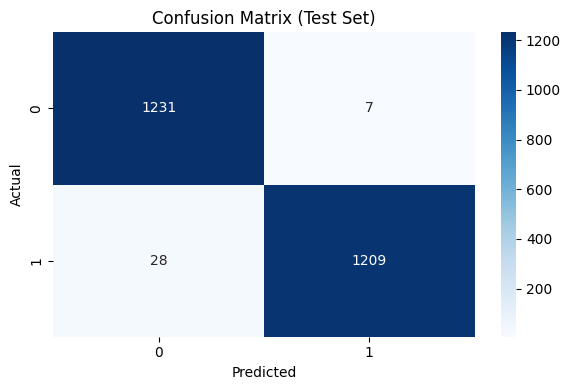

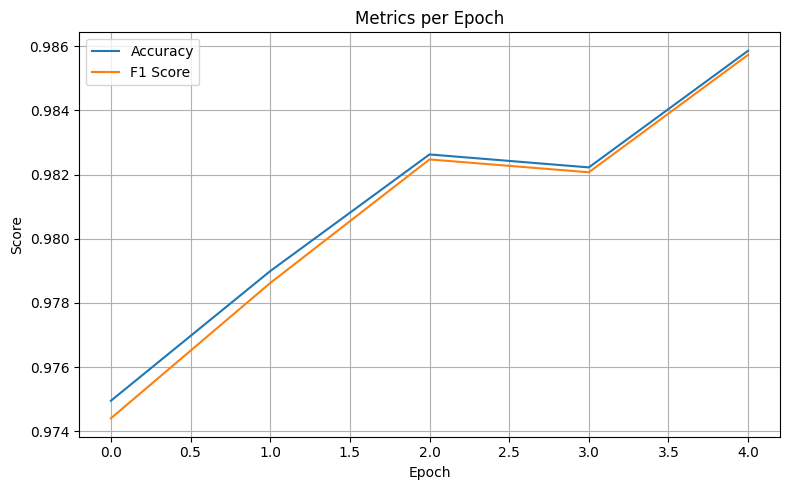

{'Model': 'DistilBERT',
 'Training Time (s)': 1240.13,
 'CPU Usage (%)': 63.1,
 'RAM Usage (MB)': 656.88,
 'Final Test Acc': 0.9859,
 'Final Test F1': 0.9857}

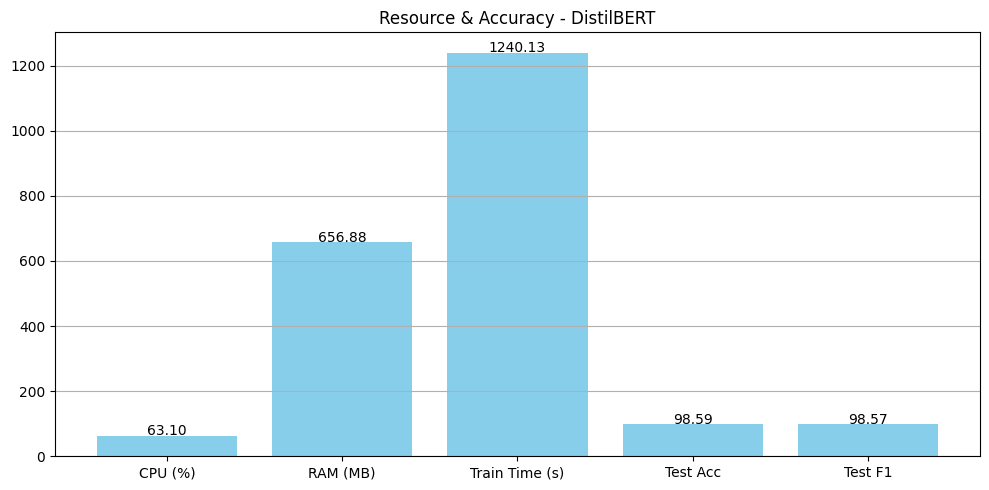

✅ Training & Evaluasi Selesai. Semua file disimpan di:
/content/drive/My Drive/Colab Notebooks/5. Output/3. Transformers/Text Only


In [ ]:
# 384 Token
# ========================== [1] Install & Import ==========================
!pip install transformers datasets evaluate --quiet

import os, time, random, psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, DistilBertModel, PreTrainedModel, DistilBertConfig, DataCollatorWithPadding
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import Dataset
from google.colab import drive

# ========================== [2] Seed & Mount Drive ==========================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
drive.mount('/content/drive')

# ========================== [3] Load Dataset ==========================
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Dataset After Preprocessing/5. Plain Text Only + Fitur PFA, Ablation dan PFI.csv")
df.dropna(subset=["filename", "label", "plain_text_only"], inplace=True)
df["text"] = df["plain_text_only"].astype(str)
df["label"] = df["label"].astype(int)

# ========================== [4] Train-Val-Test Split (60/20/20) ==========================
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df["label"], random_state=seed)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=seed)

# ========================== [5] Tokenizer & Dataset ==========================
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize_function(example):
    encoding = tokenizer(
        example["text"],
        truncation=True,
        padding=False,  # atau True jika ingin padding langsung
        max_length=384  # ⬅️ Batasi ke 128 token
    )
    return encoding

train_dataset = Dataset.from_pandas(train_df[["text", "label"]].reset_index(drop=True)).map(tokenize_function, batched=True)
val_dataset   = Dataset.from_pandas(val_df[["text", "label"]].reset_index(drop=True)).map(tokenize_function, batched=True)
test_dataset  = Dataset.from_pandas(test_df[["text", "label"]].reset_index(drop=True)).map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#========================OPTIMIZER======================================
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(logits, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class CustomDistilBERT(PreTrainedModel):
    config_class = DistilBertConfig

    def __init__(self, config):
        super().__init__(config)
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.hidden = nn.Sequential(
            nn.Linear(config.dim, 256),     # 768 → 256
            #nn.BatchNorm1d(256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, config.num_labels)
        )
        self.focal_loss = FocalLoss(alpha=0.25, gamma=2.0)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]  # Ambil token [CLS]
        logits = self.hidden(cls_output)

        loss = None
        if labels is not None:
            loss = self.focal_loss(logits, labels)

        return SequenceClassifierOutput(loss=loss, logits=logits)

# ========================== [6] Model Path Check ==========================
model_dir = "/content/drive/My Drive/Colab Notebooks/5. Output/3. Transformers/Text Only"
os.makedirs(model_dir, exist_ok=True)

model_path = model_dir
retrain = input(f"Model telah ada? (y=latih ulang / n=gunakan saja): ").strip().lower() == 'y'

if os.path.exists(model_path) and not retrain:
  config = DistilBertConfig.from_pretrained(model_path)
  model = CustomDistilBERT(config)
  model.load_state_dict(torch.load(os.path.join(model_path, "pytorch_model.bin")))
else:
  config = DistilBertConfig.from_pretrained("distilbert-base-uncased", num_labels=2)
  model = CustomDistilBERT(config)

# ========================== [7] Training Arguments ==========================
output_dir = "/content/drive/My Drive/Colab Notebooks/5. Output/3. Transformers/Text Only"
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir=os.path.join(output_dir, "logs"),
    num_train_epochs=4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=10,
    save_total_limit=2,
    report_to="none",
    logging_first_step=True,

    # 🔽 Tambahkan ini di bagian bawah
    lr_scheduler_type="linear",
    warmup_steps=200
)

# ========================== [8] Metrics ==========================
history = {"eval_accuracy": [], "eval_f1": [], "eval_loss": []}
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    history["eval_accuracy"].append(acc)
    history["eval_f1"].append(f1)
    return {"accuracy": acc, "f1": f1}

# ========================== [9] Resource Tracking & Training ==========================
if retrain or not os.path.exists(model_path):
    start_time = time.time()
    cpu_before = psutil.cpu_percent(interval=None)
    ram_before = psutil.Process().memory_info().rss / (1024 * 1024)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    torch.save(model.state_dict(), os.path.join(model_path, "pytorch_model.bin"))
    tokenizer.save_pretrained(model_path)

# ========================== [10] Final Evaluation & Save Results ==========================
trainer.model.eval()
preds = trainer.predict(test_dataset)

#End Training
cpu_after = psutil.cpu_percent(interval=None)
ram_after = psutil.Process().memory_info().rss / (1024 * 1024)
end_time = time.time()

y_true = np.array(preds.label_ids)
y_pred = np.argmax(preds.predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.show()

# False Predictions
test_df = test_df.reset_index(drop=True)
false_preds = test_df.copy()
false_preds["True Label"] = y_true
false_preds["Predicted Label"] = y_pred
false_preds = false_preds[false_preds["True Label"] != false_preds["Predicted Label"]]
false_preds.to_csv(f"{output_dir}/false_predictions.csv", index=False)

# Plot Accuracy & F1 over Epochs
if len(history["eval_accuracy"]) > 0:
    plt.figure(figsize=(8, 5))
    plt.plot(history["eval_accuracy"], label='Accuracy')
    plt.plot(history["eval_f1"], label='F1 Score')
    plt.title("Metrics per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/training_metrics_curve.png")
    plt.show()

# Resource Log
log = {
    "Model": "DistilBERT",
    "Training Time (s)": round(end_time - start_time, 2) if retrain else "Loaded",
    "CPU Usage (%)": cpu_after if retrain else "N/A",
    "RAM Usage (MB)": round(ram_after - ram_before, 2) if retrain else "N/A",
    "Final Test Acc": round(accuracy_score(y_true, y_pred), 4),
    "Final Test F1": round(f1_score(y_true, y_pred), 4)
}

def plot_resource_and_accuracy(log):
    plt.figure(figsize=(10, 5))
    labels = ["CPU (%)", "RAM (MB)", "Train Time (s)", "Test Acc", "Test F1"]
    values = [
        log["CPU Usage (%)"] if isinstance(log["CPU Usage (%)"], (int, float)) else 0,
        log["RAM Usage (MB)"] if isinstance(log["RAM Usage (MB)"], (int, float)) else 0,
        log["Training Time (s)"] if isinstance(log["Training Time (s)"], (int, float)) else 0,
        log["Final Test Acc"] * 100,
        log["Final Test F1"] * 100
    ]
    bars = plt.bar(labels, values, color='skyblue')
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{value:.2f}", ha='center')
    plt.title(f"Resource & Accuracy - {log['Model']}")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/resource_accuracy_plot.png")
    plt.show()

display (log)
plot_resource_and_accuracy(log)
print("✅ Training & Evaluasi Selesai. Semua file disimpan di:")
print(output_dir)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.2 MB/s eta 0:00:00
Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/7425 [00:00<?, ? examples/s]

Map:   0%|          | 0/2475 [00:00<?, ? examples/s]

Map:   0%|          | 0/2475 [00:00<?, ? examples/s]

Model sudah ada? (y = latih ulang / n = gunakan model tersimpan): y


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

<ipython-input-1-d0712db5204d>:220: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.003989,0.980606,0.980263
2,No log,0.002903,0.985859,0.985697
3,0.011400,0.002810,0.986263,0.986156


0.9861563517915309
/content/drive/My Drive/Colab Notebooks/5. Output/3. Transformers/Text Only/checkpoint-699


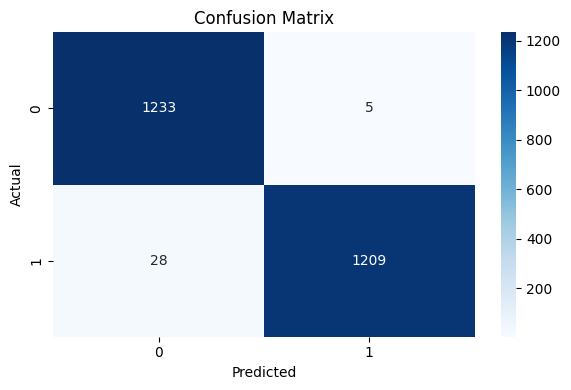

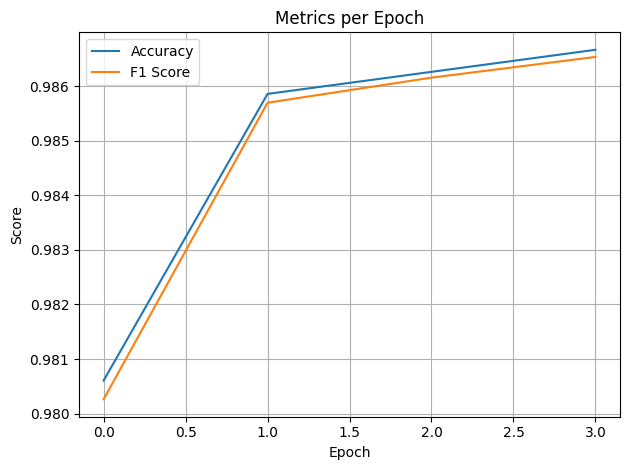

{'Model': 'MultimodalDistilBERT',
 'Training Time (s)': 814.56,
 'CPU Usage (%)': 65.2,
 'RAM Usage (MB)': 579.22,
 'Final Test Acc': 0.9867,
 'Final Test F1': 0.9865}

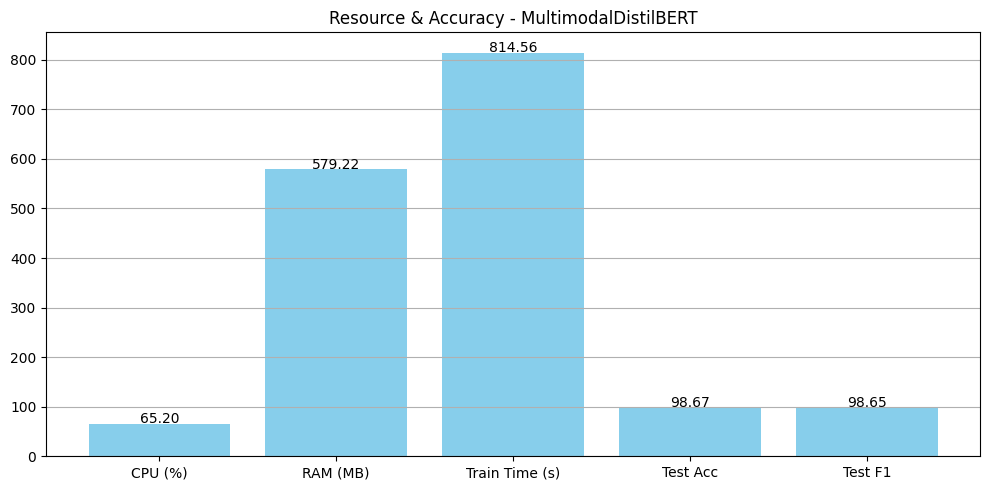

✅ Training & Evaluasi Multimodal Selesai. Semua file disimpan di:
/content/drive/My Drive/Colab Notebooks/5. Output/3. Transformers/Text Only


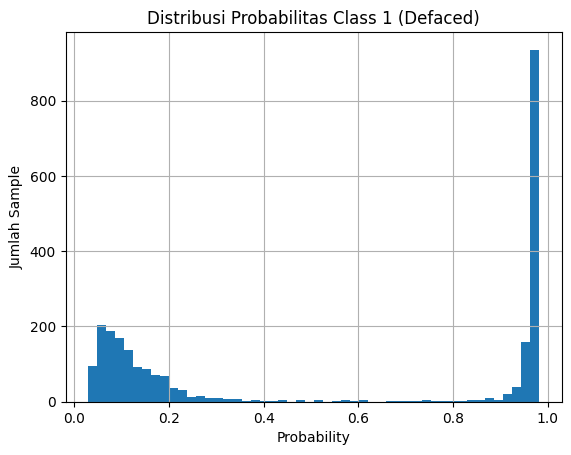

In [ ]:
# Text Only + Fitur + 384
# ========================== [1] Install & Import ==========================
!pip install transformers datasets evaluate --quiet

import os, time, random, psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from transformers import DistilBertTokenizerFast, DistilBertModel
from transformers import Trainer, TrainingArguments, PreTrainedModel, PretrainedConfig, EarlyStoppingCallback
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import DataCollatorWithPadding
from datasets import Dataset, DatasetDict
from google.colab import drive

# ========================== [2] Seed & Mount Drive ==========================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
drive.mount('/content/drive')

# ========================== [3] Load Dataset ==========================
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Dataset After Preprocessing/5. Plain Text Only + Fitur PFA, Ablation dan PFI.csv")
df.dropna(subset=["filename", "label", "plain_text_only"], inplace=True)
df["text"] = df["plain_text_only"].astype(str)
df["label"] = df["label"].astype(int)

# ========================== [4] Pilih & Normalisasi Fitur Numerik ==========================
numeric_features = [
    'total_tag','found_keywords', 'total_found_keywords', 'alert_keywords_combo','external_links',
    'js_autoplay_audio','img_tags','css_entropy','html_comment_count',
    'dom_max_depth','visual_density'
]
df[numeric_features] = df[numeric_features].fillna(0)
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# ========================== [5] Train-Val-Test Split (60/20/20) ==========================
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df["label"], random_state=seed)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=seed)

# ========================== [6] Tokenizer & Dataset ==========================
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def preprocess_function(example):
    encoding = tokenizer(
        example["text"],
        truncation=True,
        padding=False,  # atau True jika ingin padding langsung
        max_length=384  # ⬅️ Batasi ke 128 token
    )
    encoding["features"] = [example[feat] for feat in numeric_features]
    return encoding

def df_to_dataset(df):
    return Dataset.from_pandas(df[["text", "label"] + numeric_features])

dataset = DatasetDict({
    "train": df_to_dataset(train_df),
    "val": df_to_dataset(val_df),
    "test": df_to_dataset(test_df)
}).map(preprocess_function)

#=========================Attention Gate=============================
class AttentionGate(nn.Module):
    def __init__(self, feature_dim, hidden_dim=32):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, feature_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        weights = self.attn(x)  # Output: (batch_size, feature_dim)
        return x * weights  # Element-wise multiplication

# ========================== [7] Konfigurasi Model Multimodal ==========================
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=3, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(logits, targets)
        pt = torch.exp(-ce_loss)  # Probabilitas prediksi terhadap label yang benar
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class MultimodalConfig(PretrainedConfig):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.num_labels = 2
        self.num_features = len(numeric_features)
        self.hidden_size = 768

class MultimodalBERT(PreTrainedModel):
    config_class = MultimodalConfig

    def __init__(self, config):
        super().__init__(config)
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")

        self.feature_attention = AttentionGate(config.num_features)

        self.feature_mlp = nn.Sequential(
            nn.Linear(config.num_features, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        #self.classifier = nn.Linear(config.hidden_size + 64, config.num_labels)
        self.fusion_layer = nn.Sequential(
            nn.Linear(config.hidden_size + 64, 256),
            #nn.BatchNorm1d(256),
            nn.LayerNorm(256),  # Replace with LayerNorm
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, config.num_labels)
        )

        # ⬇️ Tambahkan focal loss instance
        self.focal_loss = FocalLoss(alpha=0.25, gamma=2.0)

    def forward(self, input_ids=None, attention_mask=None, features=None, labels=None, output_attn=False):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]

        # Apply attention gating
        weights = self.feature_attention.attn(features)
        gated_features = self.feature_attention(features)
        feature_output = self.feature_mlp(gated_features)

        concat = torch.cat([cls_output, feature_output], dim=1)
        logits = self.fusion_layer(concat)

        loss = None
        if labels is not None:
            loss = self.focal_loss(logits, labels)

        if output_attn:
            return logits, weights

        return SequenceClassifierOutput(loss=loss, logits=logits)

# ========================== [8] Collate Function & Metric Logging ==========================
def collate_fn(batch):
    input_ids = [torch.tensor(example['input_ids']) for example in batch]
    attention_mask = [torch.tensor(example['attention_mask']) for example in batch]
    features = [torch.tensor(example['features']) for example in batch]
    labels = torch.tensor([example['label'] for example in batch])
    return {
        "input_ids": torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True),
        "attention_mask": torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True),
        "features": torch.stack(features),
        "labels": labels
    }

history = {"eval_loss": [], "eval_accuracy": [], "eval_f1": []}
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    history["eval_accuracy"].append(acc)
    history["eval_f1"].append(f1)
    return {"accuracy": acc, "f1": f1}

# ========================== [9] Training Arguments ==========================
output_dir = "/content/drive/My Drive/Colab Notebooks/5. Output/3. Transformers/Text Only"
model_path = os.path.join(output_dir, "best_model")
os.makedirs(model_path, exist_ok=True)

training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir=os.path.join(output_dir, "logs"),
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    report_to="none",

    # 🔽 Tambahkan ini di bagian bawah
    lr_scheduler_type="linear",
    warmup_steps=200
)


# ========================== [10] Load atau Train Model ==========================
retrain = input("Model sudah ada? (y = latih ulang / n = gunakan model tersimpan): ").strip().lower() == 'y'
if os.path.exists(model_path) and not retrain:
    model = MultimodalBERT(MultimodalConfig.from_pretrained(model_path))
else:
    model = MultimodalBERT(MultimodalConfig())

    trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=dataset["train"],
      eval_dataset=dataset["val"],
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
      data_collator=collate_fn,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    start_time = time.time()
    cpu_before = psutil.cpu_percent(interval=None)
    ram_before = psutil.Process().memory_info().rss / (1024 * 1024)

    trainer.train()
    model.save_pretrained(model_path)

# ========================== [11] Evaluasi Akhir & Simpan Hasil ==========================
preds = trainer.predict(dataset["test"])

#End Resource
cpu_after = psutil.cpu_percent(interval=None)
ram_after = psutil.Process().memory_info().rss / (1024 * 1024)
ram_usage = ram_after - ram_before
end_time = time.time()

y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print(trainer.state.best_metric)
print(trainer.state.best_model_checkpoint)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.show()

test_df = test_df.reset_index(drop=True)
false_preds = test_df.copy()
false_preds["True Label"] = y_true
false_preds["Predicted Label"] = y_pred
false_preds = false_preds[false_preds["True Label"] != false_preds["Predicted Label"]]
false_preds.to_csv(f"{output_dir}/false_predictions.csv", index=False)

plt.plot(history["eval_accuracy"], label="Accuracy")
plt.plot(history["eval_f1"], label="F1 Score")
plt.title("Metrics per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/training_metrics_curve.png")
plt.show()

# ========================== [12] Resource Log ==========================
log = {
    "Model": "MultimodalDistilBERT",
    "Training Time (s)": round(end_time - start_time, 2),
    "CPU Usage (%)": cpu_after,
    "RAM Usage (MB)": round(ram_usage, 2) if retrain else "N/A",
    "Final Test Acc": round(accuracy_score(y_true, y_pred), 4),
    "Final Test F1": round(f1_score(y_true, y_pred), 4)
}

def plot_resource_and_accuracy(log):
    plt.figure(figsize=(10, 5))
    labels = ["CPU (%)", "RAM (MB)", "Train Time (s)", "Test Acc", "Test F1"]
    values = [
        log["CPU Usage (%)"],
        log["RAM Usage (MB)"],
        log["Training Time (s)"],
        log["Final Test Acc"] * 100,
        log["Final Test F1"] * 100
    ]
    bars = plt.bar(labels, values, color='skyblue')
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{value:.2f}", ha='center')
    plt.title(f"Resource & Accuracy - {log['Model']}")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/resource_accuracy_plot.png")
    plt.show()

display(log)
plot_resource_and_accuracy(log)
print("✅ Training & Evaluasi Multimodal Selesai. Semua file disimpan di:")
print(output_dir)

#====================== Plot Baru ====================
import torch.nn.functional as F
prob = F.softmax(torch.tensor(preds.predictions), dim=1)
plt.hist(prob[:,1].numpy(), bins=50)
plt.title("Distribusi Probabilitas Class 1 (Defaced)")
plt.xlabel("Probability")
plt.ylabel("Jumlah Sample")
plt.grid(True)
plt.show()

### **2. Transformers TinyBert + Plain Teks**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/7425 [00:00<?, ? examples/s]

Map:   0%|          | 0/2475 [00:00<?, ? examples/s]

Map:   0%|          | 0/2475 [00:00<?, ? examples/s]

Model telah ada? (y=latih ulang / n=gunakan saja): y


<ipython-input-2-f82a837d458e>:137: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.007700,0.008380,0.963636,0.962406
2,0.009500,0.006295,0.971717,0.971217
3,0.004800,0.006249,0.972525,0.971924
4,0.006000,0.005790,0.973737,0.973372
5,0.006000,0.005761,0.975354,0.974969


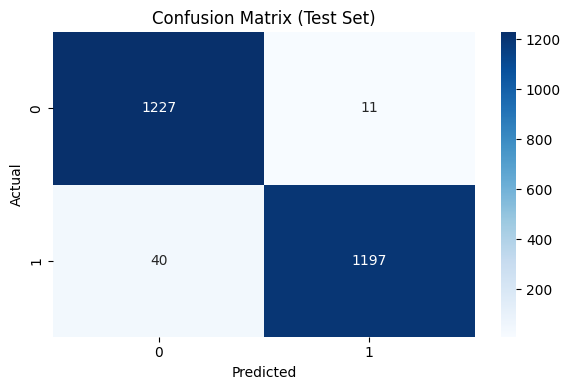

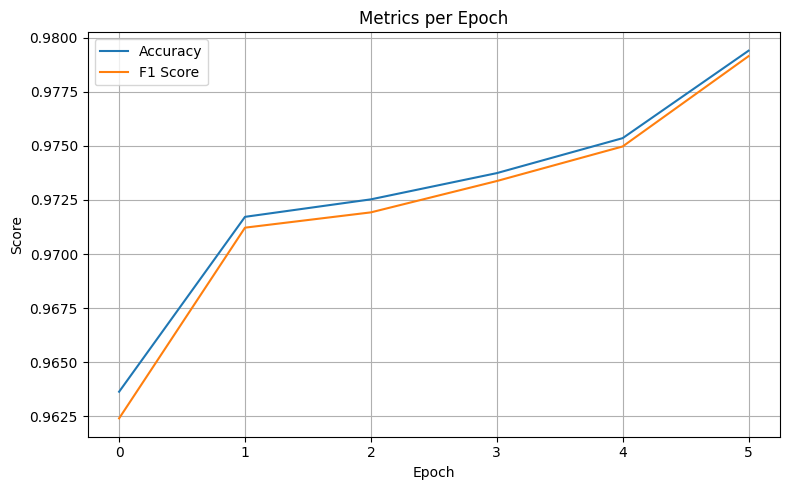

{'Model': 'TinyBERT',
 'Training Time (s)': 87.21,
 'CPU Usage (%)': 67.5,
 'RAM Usage (MB)': -54.13,
 'Final Test Acc': 0.9794,
 'Final Test F1': 0.9791}

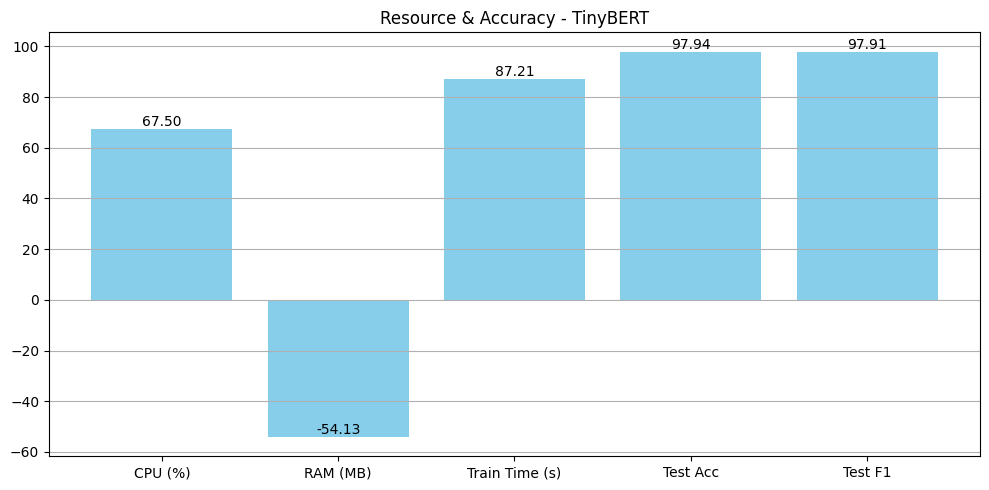

✅ Training & Evaluasi TinyBERT selesai. File disimpan di:
/content/drive/My Drive/Colab Notebooks/5. Output/3. Transformers/TinyBert


In [ ]:
# ========================== [1] Install & Import ==========================
!pip install transformers datasets evaluate --quiet

import os, time, random, psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel, PreTrainedModel, AutoConfig, Trainer, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import Dataset
from google.colab import drive

# ========================== [2] Seed & Mount ==========================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
drive.mount('/content/drive')

# ========================== [3] Load Dataset ==========================
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Dataset After Preprocessing/5. Plain Text Only + Fitur PFA, Ablation dan PFI.csv")
df.dropna(subset=["filename", "label", "plain_text_only"], inplace=True)
df["text"] = df["plain_text_only"].astype(str)
df["label"] = df["label"].astype(int)

# ========================== [4] Train-Test Split ==========================
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df["label"], random_state=seed)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=seed)

# ========================== [5] Tokenizer ==========================
model_name = "huawei-noah/TinyBERT_General_4L_312D"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding=False, max_length=128)

train_dataset = Dataset.from_pandas(train_df[["text", "label"]].reset_index(drop=True)).map(tokenize_function, batched=True)
val_dataset = Dataset.from_pandas(val_df[["text", "label"]].reset_index(drop=True)).map(tokenize_function, batched=True)
test_dataset = Dataset.from_pandas(test_df[["text", "label"]].reset_index(drop=True)).map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ========================== [6] Focal Loss & Custom Model ==========================
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(logits, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

class TinyBERTClassifier(PreTrainedModel):
    config_class = AutoConfig

    def __init__(self, config):
        super().__init__(config)
        self.bert = AutoModel.from_pretrained(model_name)
        self.hidden = nn.Sequential(
            nn.Linear(config.hidden_size, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, config.num_labels)
        )
        self.focal_loss = FocalLoss(alpha=0.25, gamma=2.0)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]
        logits = self.hidden(cls_output)
        loss = self.focal_loss(logits, labels) if labels is not None else None
        return SequenceClassifierOutput(loss=loss, logits=logits)

# ========================== [7] Model Path ==========================
output_dir = "/content/drive/My Drive/Colab Notebooks/5. Output/3. Transformers/TinyBert"
os.makedirs(output_dir, exist_ok=True)

model_path = output_dir
retrain = input("Model telah ada? (y=latih ulang / n=gunakan saja): ").strip().lower() == 'y'

if os.path.exists(model_path) and not retrain:
    config = AutoConfig.from_pretrained(model_path)
    model = TinyBERTClassifier(config)
    model.load_state_dict(torch.load(os.path.join(model_path, "pytorch_model.bin")))
else:
    config = AutoConfig.from_pretrained(model_name, num_labels=2)
    model = TinyBERTClassifier(config)

# ========================== [8] Training Arguments ==========================
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir=os.path.join(output_dir, "logs"),
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=10,
    save_total_limit=2,
    report_to="none",
    logging_first_step=True,
    lr_scheduler_type="linear",
    warmup_steps=200
)

# ========================== [9] Metrics ==========================
history = {"eval_accuracy": [], "eval_f1": []}
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    history["eval_accuracy"].append(acc)
    history["eval_f1"].append(f1)
    return {"accuracy": acc, "f1": f1}

# ========================== [10] Training ==========================
if retrain or not os.path.exists(model_path):
    start_time = time.time()
    cpu_before = psutil.cpu_percent()
    ram_before = psutil.Process().memory_info().rss / (1024 * 1024)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()
    torch.save(model.state_dict(), os.path.join(model_path, "pytorch_model.bin"))
    tokenizer.save_pretrained(model_path)

# ========================== [11] Evaluation ==========================
trainer.model.eval()
preds = trainer.predict(test_dataset)
cpu_after = psutil.cpu_percent()
ram_after = psutil.Process().memory_info().rss / (1024 * 1024)
end_time = time.time()

y_true = np.array(preds.label_ids)
y_pred = np.argmax(preds.predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.show()

# False Predictions
test_df = test_df.reset_index(drop=True)
false_preds = test_df.copy()
false_preds["True Label"] = y_true
false_preds["Predicted Label"] = y_pred
false_preds = false_preds[false_preds["True Label"] != false_preds["Predicted Label"]]
false_preds.to_csv(f"{output_dir}/false_predictions.csv", index=False)

# Metrics Plot
if len(history["eval_accuracy"]) > 0:
    plt.figure(figsize=(8, 5))
    plt.plot(history["eval_accuracy"], label='Accuracy')
    plt.plot(history["eval_f1"], label='F1 Score')
    plt.title("Metrics per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/training_metrics_curve.png")
    plt.show()

# Resource Log
log = {
    "Model": "TinyBERT",
    "Training Time (s)": round(end_time - start_time, 2) if retrain else "Loaded",
    "CPU Usage (%)": cpu_after if retrain else "N/A",
    "RAM Usage (MB)": round(ram_after - ram_before, 2) if retrain else "N/A",
    "Final Test Acc": round(accuracy_score(y_true, y_pred), 4),
    "Final Test F1": round(f1_score(y_true, y_pred), 4)
}

def plot_resource_and_accuracy(log):
    plt.figure(figsize=(10, 5))
    labels = ["CPU (%)", "RAM (MB)", "Train Time (s)", "Test Acc", "Test F1"]
    values = [
        log["CPU Usage (%)"] if isinstance(log["CPU Usage (%)"], (int, float)) else 0,
        log["RAM Usage (MB)"] if isinstance(log["RAM Usage (MB)"], (int, float)) else 0,
        log["Training Time (s)"] if isinstance(log["Training Time (s)"], (int, float)) else 0,
        log["Final Test Acc"] * 100,
        log["Final Test F1"] * 100
    ]
    bars = plt.bar(labels, values, color='skyblue')
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{value:.2f}", ha='center')
    plt.title(f"Resource & Accuracy - {log['Model']}")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/resource_accuracy_plot.png")
    plt.show()

display(log)
plot_resource_and_accuracy(log)
print("✅ Training & Evaluasi TinyBERT selesai. File disimpan di:")
print(output_dir)
